## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Imports dependencies

In [1]:
import numpy as np
import cv2
import glob
import pickle as pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

from lane_lib import calib
from lane_lib import perspective
from lane_lib import detector
from lane_lib import masking

## Camera calibration with chessboard images

In [2]:
def camera_calibration(outfile,
                       silent = True, 
                       corners_shape = (9, 6), 
                       img_glob = "camera_cal/calibration*.jpg"):

        # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((corners_shape[0] * corners_shape[1], 3), np.float32)
        objp[:,:2] = np.mgrid[0: corners_shape[0], 0: corners_shape[1]].T.reshape(-1, 2) # x, y coordinates

        # Arrays to store object points and image points from all the images.
        obj_points = [] # 3d points in real world space
        img_points = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob(img_glob)
        
        i = 0
        if not silent is True:
            plt.figure(figsize = (20, 10))
        
        # Step through the list and search for chessboard corners
        for fname in images:
            # Read image
            img = mpimg.imread(fname)
            # Convert to grayscale
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(img_gray, corners_shape, None)
            
            i += 1
            
            # If found, add object points, image points
            if ret == True:
                obj_points.append(objp)
                img_points.append(corners)
                
                if not silent is True:
                    # Draw and display the corners
                    cv2.drawChessboardCorners(img, corners_shape, corners, ret)
                    
            if not silent is True:
                plt.subplot(4, 5, i)
                plt.imshow(img)
                plt.axis('off')

        # Perform camera calibration given the object and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_gray.shape[::-1], None, None)

        # Pickle the data and save it
        calib_data = {'cam_matrix': mtx,
                      'dist_coeffs': dist,
                      'img_size': img.shape}
        
        with open(outfile, 'wb') as f:
            pickle.dump(calib_data, f)
        
        return ret, mtx, dist

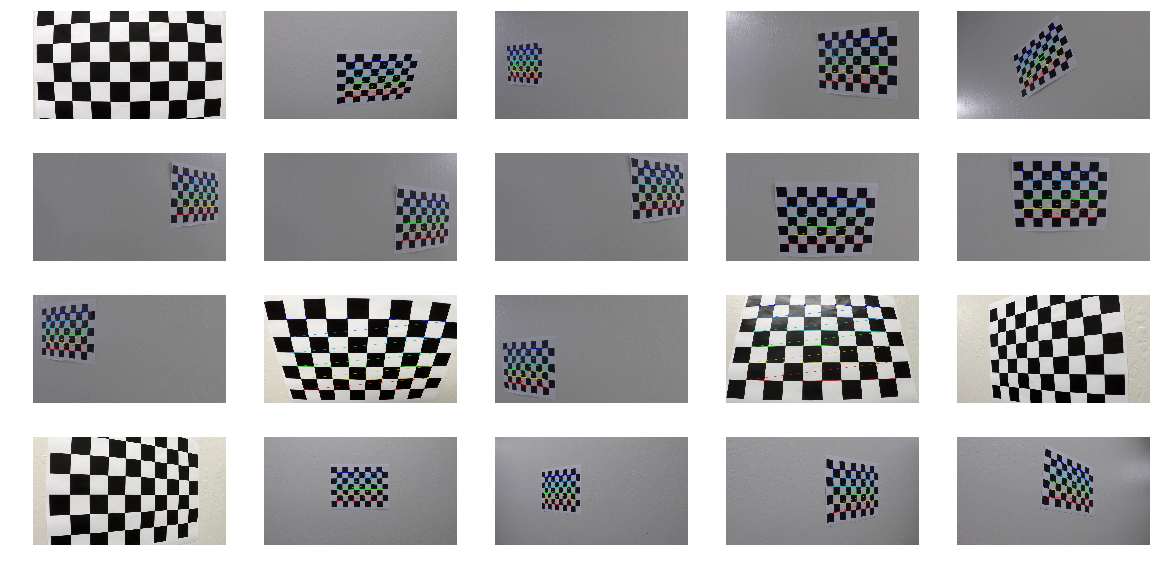

In [3]:
# Intrinsic camera calibration
CALIB_FILE_NAME = "calib.p"
ret, mtx, dist = camera_calibration(CALIB_FILE_NAME, False)

In [4]:
with open(CALIB_FILE_NAME, 'rb') as f:
    calib_data = pickle.load(f)
    mtx = calib_data["cam_matrix"]
    dist = calib_data["dist_coeffs"]

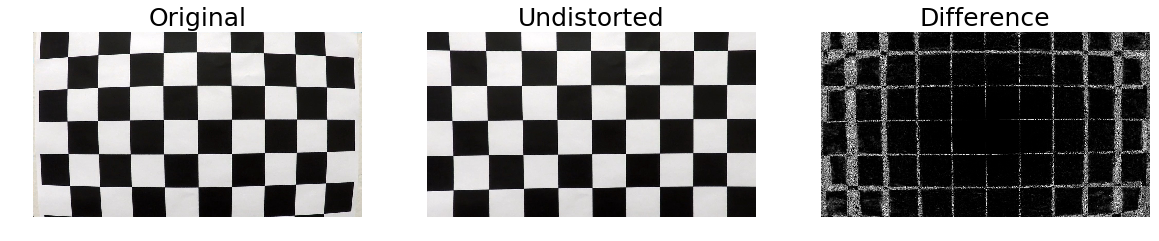

In [5]:
# Original image
img_orig = mpimg.imread("camera_cal/calibration1.jpg")

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_orig)
plt.title('Original', fontsize=25)
plt.axis('off');

# Undistored image
img_undist = cv2.undistort(img_orig, mtx, dist, None, mtx)

plt.subplot(1, 3, 2)
plt.imshow(img_undist)
plt.title('Undistorted', fontsize=25)
plt.axis('off');

# Difference before and after distortion correction
img_diff = np.sum((img_orig - img_undist)**2, axis=2)

plt.subplot(1, 3, 3)
plt.imshow(img_diff, cmap='gray')
plt.title('Difference', fontsize=25)
plt.axis('off');

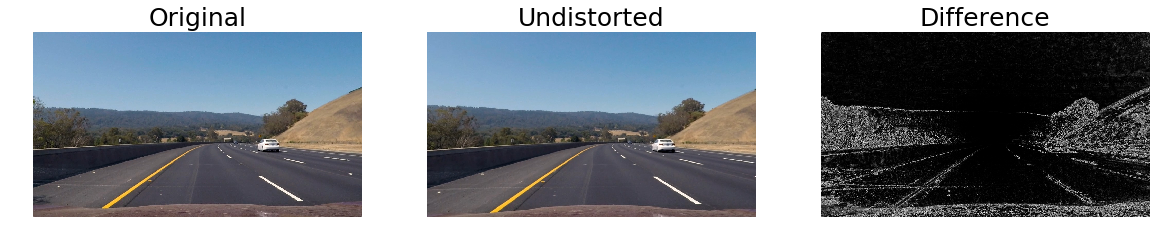

In [6]:
# Original image
img_orig = mpimg.imread("test_images/test3.jpg")

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_orig)
plt.title('Original', fontsize=25)
plt.axis('off');

# Undistored image
img_undist = cv2.undistort(img_orig, mtx, dist, None, mtx)

plt.subplot(1, 3, 2)
plt.imshow(img_undist)
plt.title('Undistorted', fontsize=25)
plt.axis('off');

# Difference before and after distortion correction
img_diff = np.sum((img_orig - img_undist)**2, axis=2)

plt.subplot(1, 3, 3)
plt.imshow(img_diff, cmap='gray')
plt.title('Difference', fontsize=25)
plt.axis('off');

## Perspective Transformation

Applying perspective transformation to get bird's eye view.

In [7]:
def perspective_transform(img, silent = True):
    
    img_size = img.shape
    
    # Define source image polygonal region of interest
    t_roi_y = np.uint(img_size[0] / 1.5)  # top y
    b_roi_y = np.uint(img_size[0])        # bottom y
    
    roi_x = np.uint(img_size[1] / 2)
    tl_roi_x = roi_x - 0.2 * np.uint(img_size[1] / 2) # top-left x
    tr_roi_x = roi_x + 0.2 * np.uint(img_size[1] / 2) # top-right x
    bl_roi_x = roi_x - 0.9 * np.uint(img_size[1] / 2) # bottom-left x
    br_roi_x = roi_x + 0.9 * np.uint(img_size[1] / 2) # bottom-right x
    
    src = np.float32([[bl_roi_x, b_roi_y],
                      [br_roi_x, b_roi_y], 
                      [tr_roi_x, t_roi_y], 
                      [tl_roi_x, t_roi_y]])
    
    # Define destination image rectangle
    dst = np.float32([[0, img_size[0]], 
                      [img_size[1], img_size[0]], 
                      [img_size[1], 0], 
                      [0,0]])
    
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    if not silent is True:
        
        # Print source and destination points to warp
        print("Source Points")
        print(src)
        print("Destination Points")
        print(dst)
        
        # Plot
        plt.figure(figsize=(20, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        for i in range(4):
            plt.plot(src[i][0], src[i][1], 'bo')
        plt.title('Undistored Image', fontsize=25)
        plt.axis('off');
        
        plt.subplot(1, 2, 2)
        plt.imshow(warped, cmap='gray')
        for i in range(4):
            plt.plot(dst[i][0], dst[i][1], 'bo')
        plt.title('Bird-eye view', fontsize=25)
        plt.axis('off');
        
    return warped, M, Minv

Source Points
[[   64.   720.]
 [ 1216.   720.]
 [  768.   480.]
 [  512.   480.]]
Destination Points
[[    0.   720.]
 [ 1280.   720.]
 [ 1280.     0.]
 [    0.     0.]]


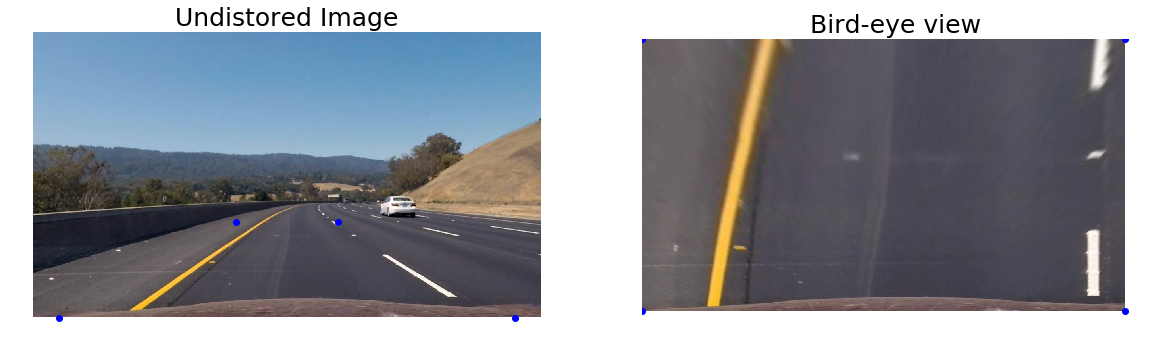

In [8]:
warped, M, Minv = perspective_transform(img_undist, False)

In [9]:
print(M)

[[ -8.33333333e-01  -1.55555556e+00   1.17333333e+03]
 [ -1.44328993e-15  -2.25000000e+00   1.08000000e+03]
 [ -2.49366500e-18  -2.43055556e-03   1.00000000e+00]]


Source Points
[[   64.   720.]
 [ 1216.   720.]
 [  768.   480.]
 [  512.   480.]]
Destination Points
[[    0.   720.]
 [ 1280.   720.]
 [ 1280.     0.]
 [    0.     0.]]


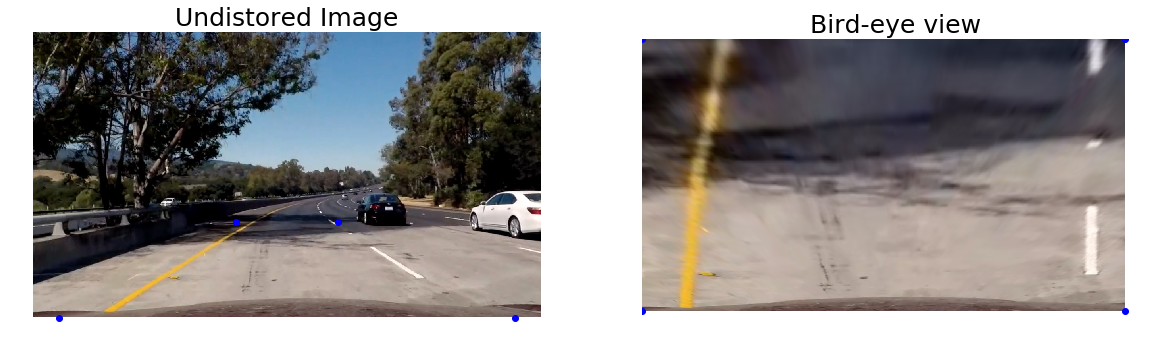

In [10]:
img_orig2 = mpimg.imread("test_images/test5.jpg")
img_undist2 = cv2.undistort(img_orig2, mtx, dist, None, mtx)
warped2, M2, Minv2 = perspective_transform(img_undist2, False)

## Apply colour masking
After perspective transformation, we can apply colour masking to segment yellow and white lane markings.

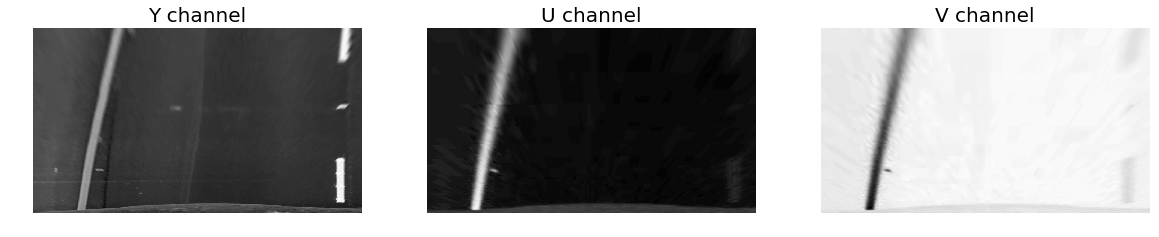

In [11]:
img_yuv = cv2.cvtColor(warped, cv2.COLOR_RGB2YUV)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow(img_yuv[:, :, 0], cmap='gray')
plt.title('Y channel', fontsize=20)
plt.axis('off');

plt.subplot(1, 3, 2)
plt.imshow(img_yuv[:, :, 1], cmap='gray')
plt.title('U channel', fontsize=20)
plt.axis('off');

plt.subplot(1, 3, 3)
plt.imshow(img_yuv[:, :, 2], cmap='gray')
plt.title('V channel', fontsize=20)
plt.axis('off');

In [12]:
# Filter Y-channel lane colour
def colour_filter_y_channel(img, threshold=(0, 255)):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_y = img_yuv[:, :, 0]
    img_binary = np.zeros_like(img_y)
    img_binary[(img_y > threshold[0]) & (img_y <= threshold[1])] = 1

    return img_binary

# Filter V-channel lane colour
def colour_filter_v_channel(img, threshold=(0, 255)):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_v = img_yuv[:, :, 2]
    img_binary = np.zeros_like(img_v)
    img_binary[(img_v > threshold[0]) & (img_v <= threshold[1])] = 1

    return img_binary

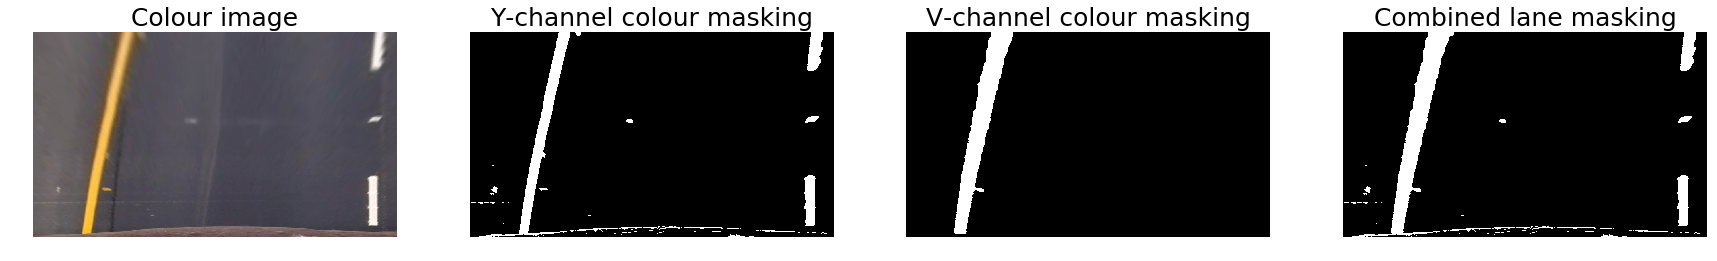

In [13]:
# -- Colour masking -- #
img_masked_y_channel = colour_filter_y_channel(warped, (110, 255))
img_masked_v_channel = colour_filter_v_channel(warped, (10, 110))
img_masked_colour = cv2.bitwise_or(img_masked_y_channel, img_masked_v_channel)

# Plot masking
plt.figure(figsize=(30, 4))
plt.subplot(1, 4, 1)
plt.imshow(warped)
plt.title('Colour image', fontsize=25)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_masked_y_channel, cmap='gray')
plt.title('Y-channel colour masking', fontsize=25)
plt.axis('off');

plt.subplot(1, 4, 3)
plt.imshow(img_masked_v_channel, cmap='gray')
plt.title('V-channel colour masking', fontsize=25)
plt.axis('off');

plt.subplot(1, 4, 4)
plt.imshow(img_masked_colour, cmap='gray')
plt.title('Combined lane masking', fontsize=25)
plt.axis('off');

## Apply Sobel filtering
Applying Sobel filters to L and S channels of the image

In [14]:
# Calculate directional gradient
def sobel_gradient_xy(img, orient='x', threshold=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        img_s = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255 * img_abs / np.max(img_abs))

    img_binary = np.zeros_like(img_sobel)
    img_binary[(img_sobel >= threshold[0]) & (img_sobel <= threshold[1])] = 1

    return img_binary

# Calculate gradient magnitude
def sobel_gradient_magnitude(img, kernel=3, threshold=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    img_sx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    img_sy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)

    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(255 * img_s / np.max(img_s))

    img_binary = np.zeros_like(img_s)
    img_binary[(img_s >= threshold[0]) & (img_s <= threshold[1])] = 1

    return img_binary

# Calculate gradient direction
def sobel_gradient_direction(img, kernel=3, threshold=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_sx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=kernel)
    img_sy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=kernel)
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    img_binary = np.zeros_like(grad_s)
    img_binary[(grad_s >= threshold[0]) & (grad_s <= threshold[1])] = 1

    return img_binary

In [15]:
def sobel_combined(img, silent = True):
    
    # Apply Sobel edge masking
    img_abs_x = sobel_gradient_xy(img, 'x', (13, 230))
    # img_abs_y = abs_sobel_thresh(img, 'y', 5, (10, 230))
    img_g_mag = sobel_gradient_magnitude(img, 3, (20, 150))
    img_d_mag = sobel_gradient_direction(img, 3, (0.5, 1.0))
    
    # Combined masking
    mask = np.zeros_like(img_d_mag)
    mask[((img_masked_y_channel == 1) | (img_masked_v_channel == 1)) & (img_abs_x == 1) | 
          ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    
    if not silent is True:
        # Plot masking
        plt.figure(figsize=(30, 10))
        plt.subplot(1, 5, 1)
        plt.imshow(img, cmap = 'gray')
        plt.title('Bird\'s Eye View', fontsize=25)
        plt.axis('off');

        plt.subplot(1, 5, 2)
        plt.imshow(img_g_mag, cmap='gray')
        plt.title('Gradient magnitude', fontsize=25)
        plt.axis('off');

        plt.subplot(1, 5, 3)
        plt.imshow(img_d_mag, cmap='gray')
        plt.title('Direction magnitude', fontsize=25)
        plt.axis('off');

        plt.subplot(1, 5, 4)
        plt.imshow(img_abs_x, cmap='gray')
        plt.title('Gradient in x', fontsize=25)
        plt.axis('off');
        
        # plt.subplot(1, 5, 5)
        # plt.imshow(img_abs_y, cmap='gray')
        # plt.title('Gradient in y', fontsize=25)
        # plt.axis('off');

        plt.subplot(1, 5, 5)
        plt.imshow(mask, cmap='gray')
        plt.title('Combined Sobel masking', fontsize=25)
        plt.axis('off');
    
    return mask

#### Visualising Sobel filters

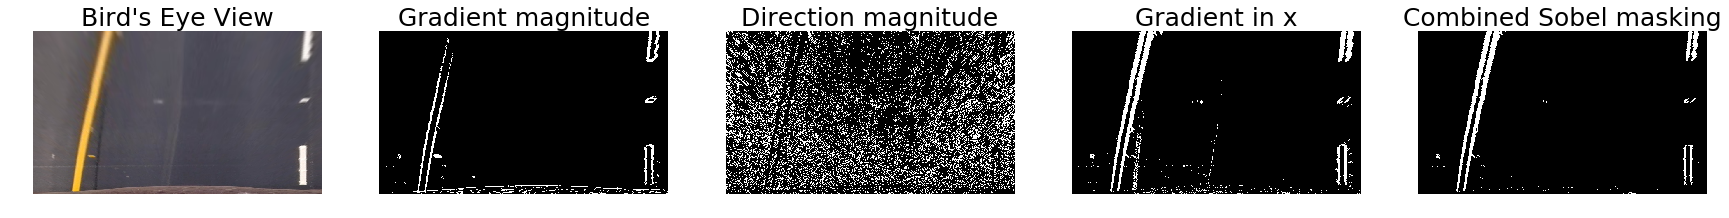

In [16]:
sobel_mask = sobel_combined(warped, silent = False)

### Combine colour mask and sobel mask

In [17]:
print(img_masked_colour.shape, img_masked_colour.dtype)
print(sobel_mask.shape, sobel_mask.dtype)

(720, 1280) uint8
(720, 1280) float64


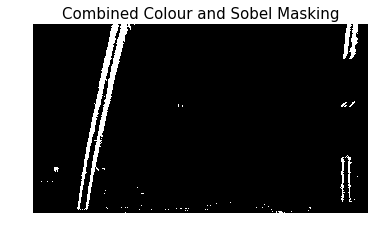

In [18]:
combined_mask = masking.BinaryMasking(warped).mask

plt.imshow(combined_mask, cmap='gray')
plt.title('Combined Colour and Sobel Masking', fontsize=15)
plt.axis('off');

## Histogram for base lane positions

In [19]:
def pipeline(fname, silent = True, show_results = True):
    img = mpimg.imread(fname)
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)

    warped, M, Minv = perspective_transform(img_undistort)
    
    binary_mask = masking.BinaryMasking(warped).mask

    # Take a histogram of the image
    histogram = np.sum(binary_mask[:, :], axis=0)
    
    if show_results:
        # Plot the result
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
        f.suptitle(fname, fontsize=14, fontweight='bold')
        f.tight_layout()

        ax1.imshow(img_undistort)
        ax1.set_title('Undistorted image', fontsize=20)
        ax1.axis('off')

        ax2.imshow(warped, cmap='gray')
        ax2.set_title('Bird Eye\'s View image', fontsize=20)
        ax2.axis('off')

        ax3.imshow(binary_mask, cmap='gray')
        ax3.set_title('Colour and Sobel masked image', fontsize=20)
        ax3.axis('off')

        ax4.plot(histogram)
        ax4.set_title('Histogram', fontsize=20)

        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
file_list = glob.glob('test_images/*.jpg')
num_files = len(file_list)
print('Number of files: %s' % num_files)
print(file_list)

Number of files: 8
['test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg']


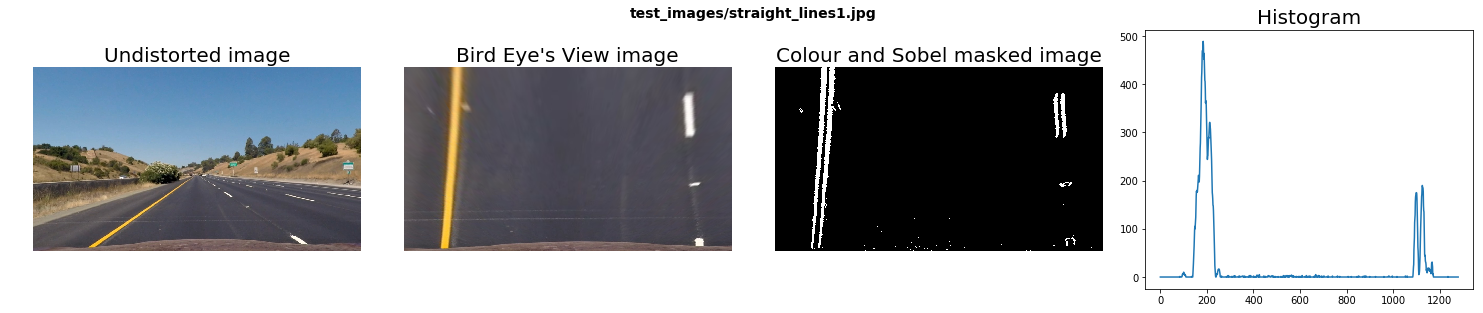

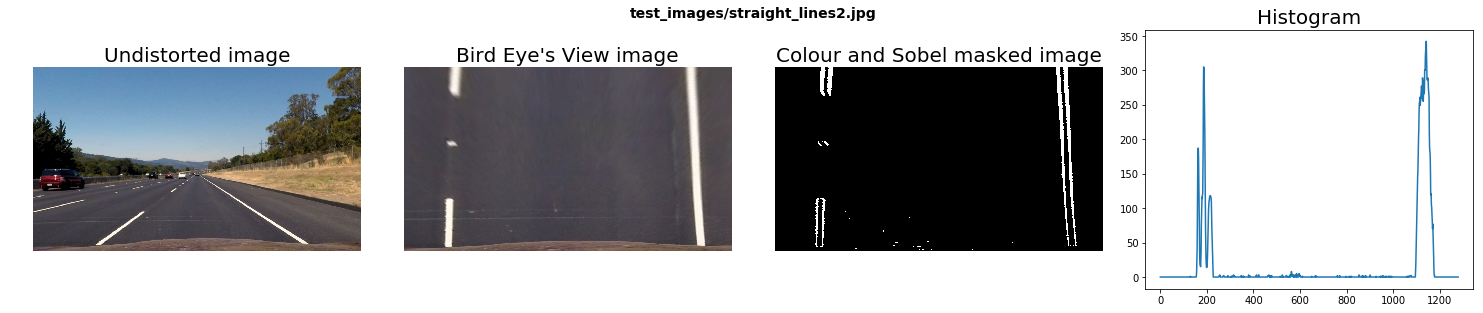

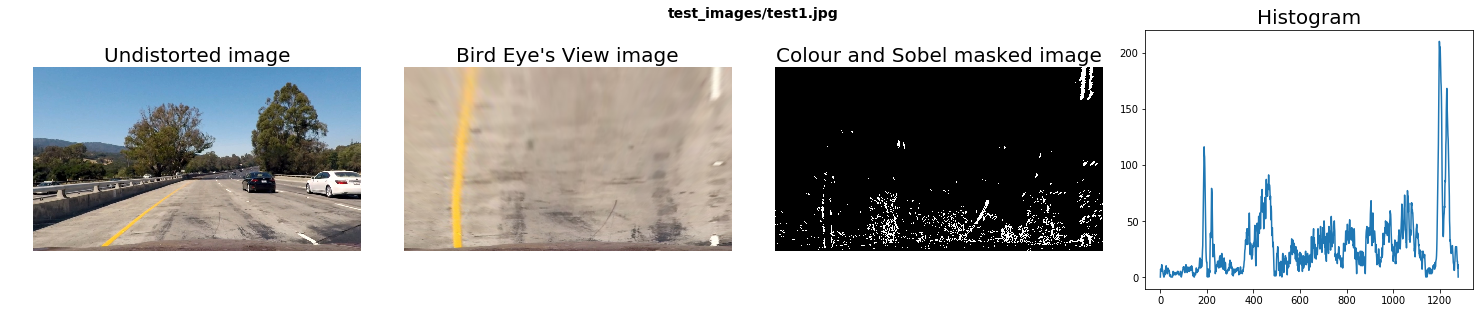

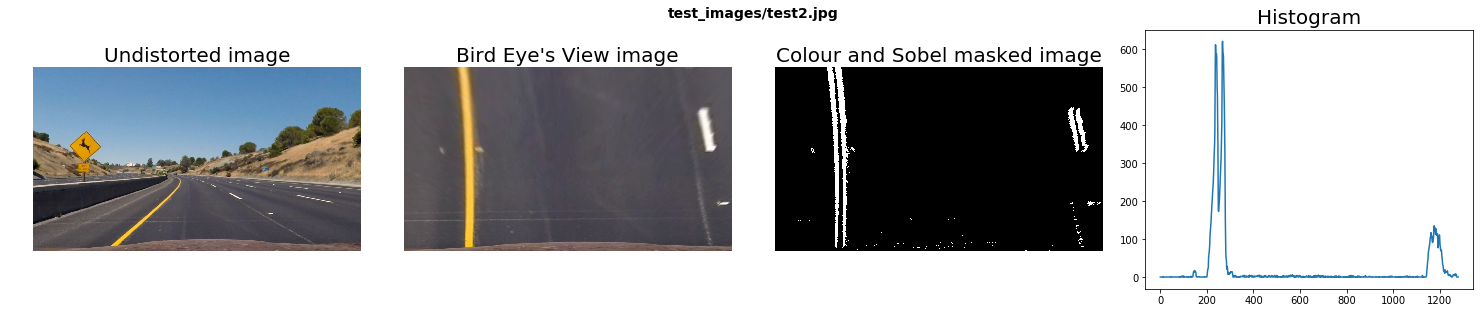

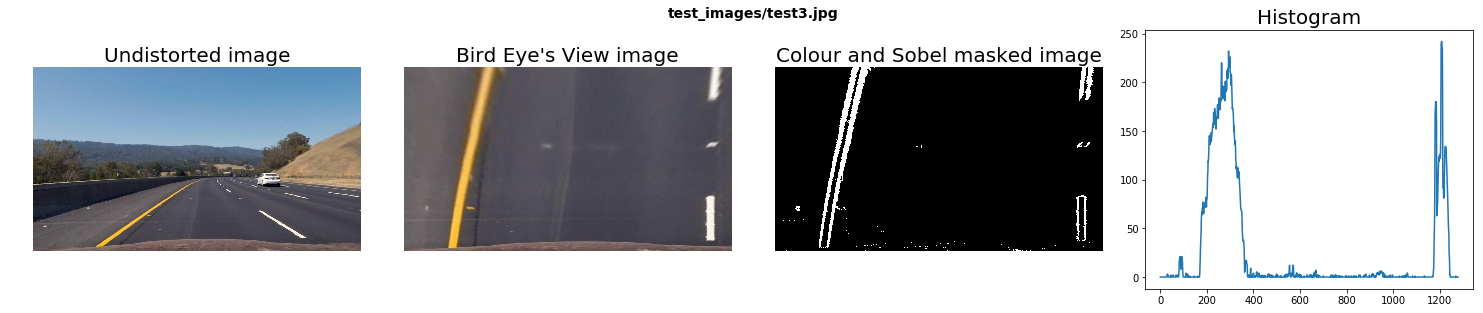

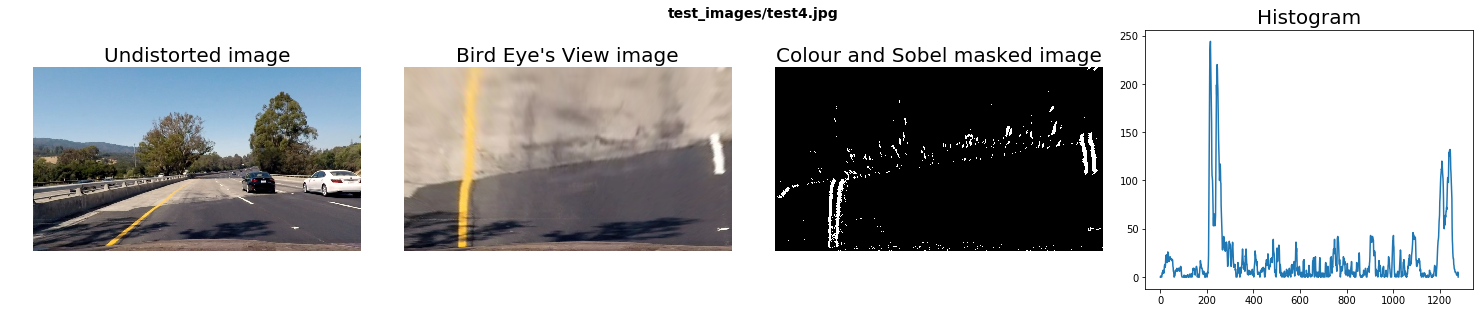

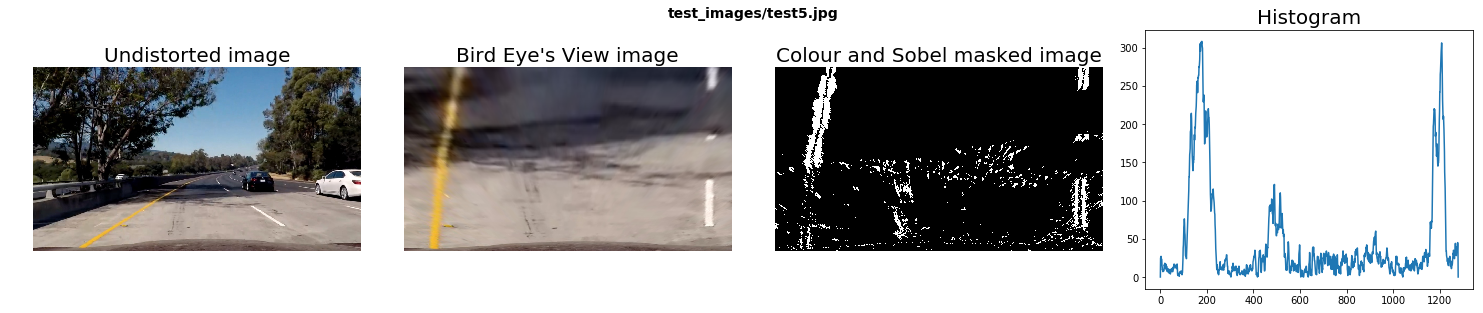

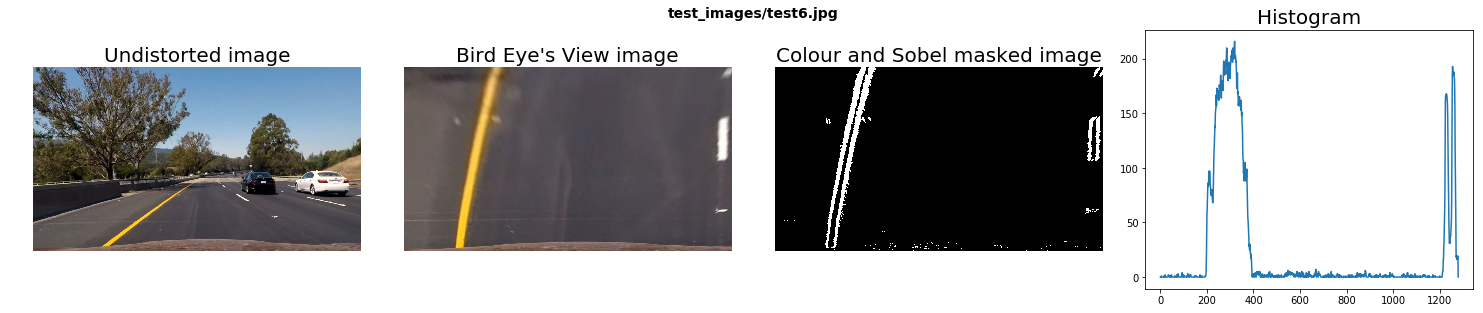

In [21]:
for f in file_list:
    pipeline(f)

### Search Windows and Fit Lane Lines (2nd order polynomial)

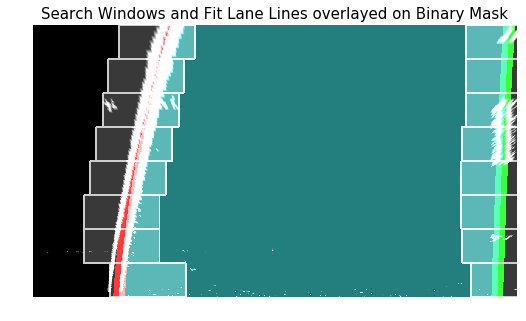

In [22]:
# Read image from file
img = mpimg.imread('test_images/test6.jpg')

# Instrinsic camera calibration
undistort = calib.CameraCalibrate()

# Perspective transformation
perspective = perspective.PerspectiveTransform(img.shape)

# Initialise lane line detector
lane_detector = detector.LaneLinesDetector(undistort.mtx, undistort.dist, 
                                           perspective.M, perspective.Minv)

# Read image frame
lane_detector.draw_debug(img)
lane_detector.initialised = False
img_search_fit_lines = lane_detector.result_img

img_search_fit_lines = cv2.cvtColor(img_search_fit_lines, cv2.COLOR_BGR2RGB)

# Plot the result
plt.figure(figsize=(12, 5))
plt.imshow(img_search_fit_lines)
plt.title('Search Windows and Fit Lane Lines overlayed on Binary Mask', fontsize=15)
plt.axis('off');

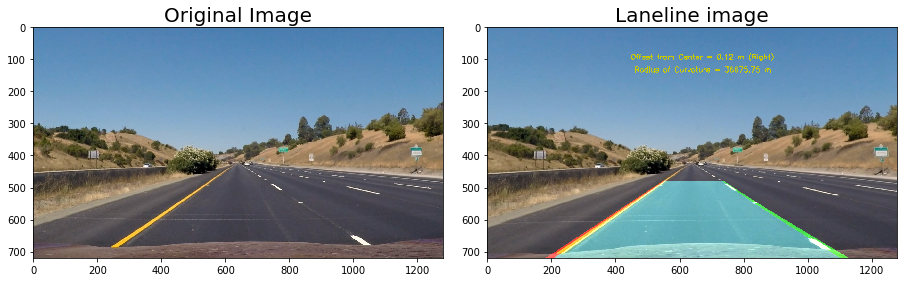

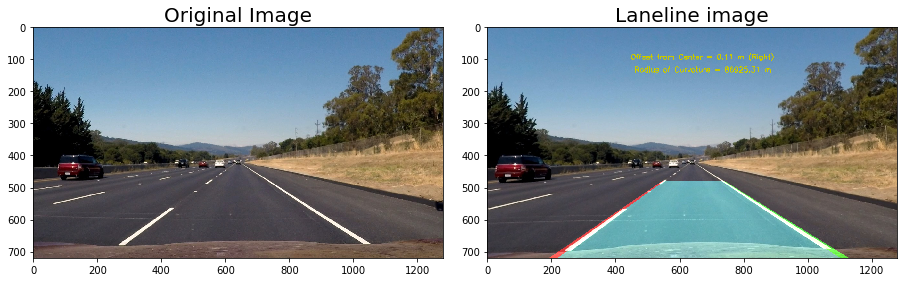

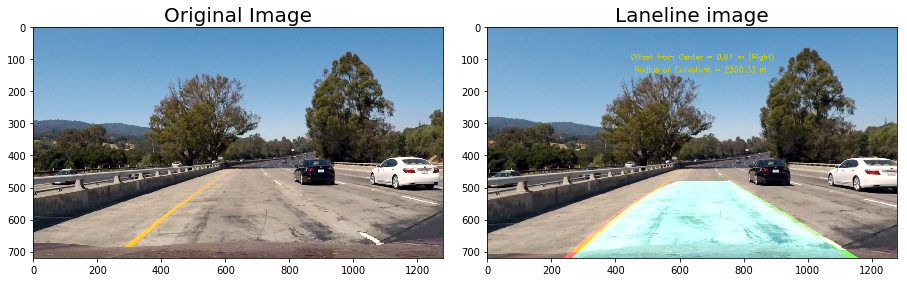

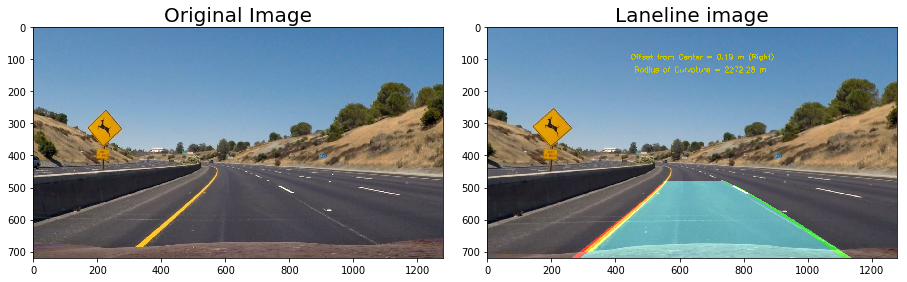

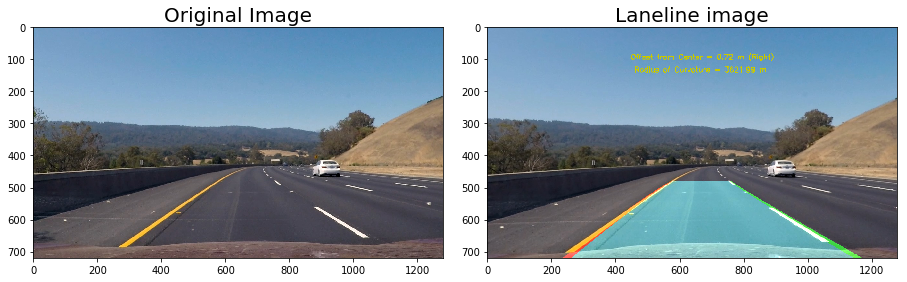

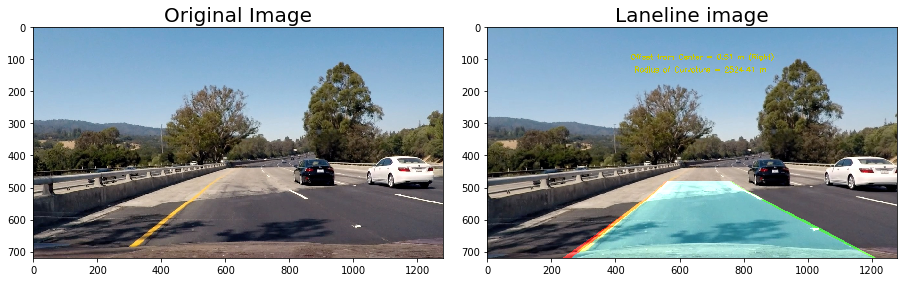

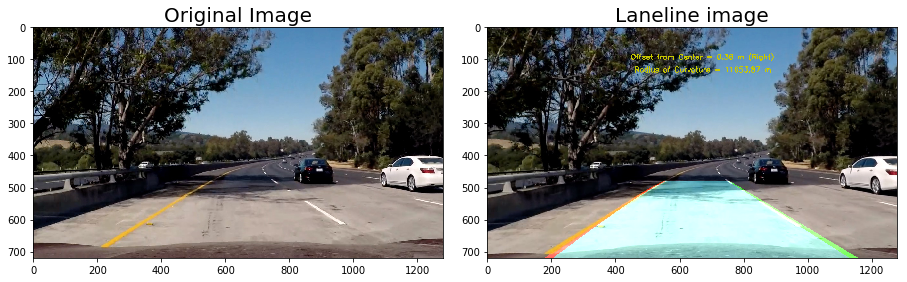

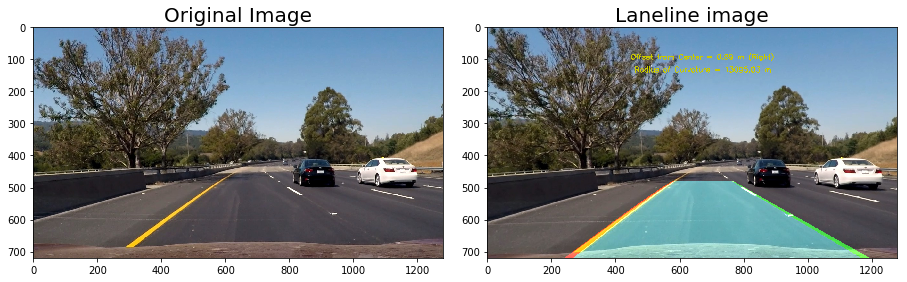

In [23]:
for fname in file_list:
    # Read image frame
    img = mpimg.imread(fname)
    lane_detector.draw(img)
    lane_detector.initialised = False
    outimg = lane_detector.result_img
    
    # Save the result to file
    out_fname = 'output_images/' + fname.split('/')[1]
    cv2.imwrite(out_fname, outimg)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    
    outimg_plt = cv2.cvtColor(outimg, cv2.COLOR_BGR2RGB)
    ax2.imshow(outimg_plt)
    ax2.set_title('Laneline image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [24]:
from moviepy.editor import *
clip = (VideoFileClip("annotated_project_video.mp4")
            .crop(y1=350, y2=630) # crop to sliding-window roi
            .resize(0.5)
            .subclip(35.4, 42.0))
clip.write_gif("output_images/overview.gif")
#             .speedx(0.5)


[MoviePy] Building file output_images/overview.gif with imageio


100%|██████████| 199/199 [00:03<00:00, 63.80it/s]


In [25]:
from IPython.display import Image
Image(url='output_images/overview.gif')